In [2]:
#import os
#os.environ['PYSYN_CDBS'] = "C:/Users/tchawla/research/HST_data/grp/redcat/trds"
#env_var = os.environ['PYSYN_CDBS']
#env_var
import numpy as np
from astropy.io import ascii
from pylab import *
from astropy.table import Table, vstack
import pandas as pd
from expecto import get_spectrum
from scipy.interpolate import RegularGridInterpolator as rgi
from itertools import product
%run Interpolate_final.ipynb
%run GetSpectra_final.ipynb
%run Binning_final.ipynb
%run AddNoise_final.ipynb
#%set_env PYSYN_CDBS = C:/Users/tchawla/research/HST_data/grp/redcat/trds

/Users/tchawla/anaconda3/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/tchawla/research/HST_data/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
#env_var

In [4]:
#PYSYN_CDBS

In [5]:
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

'''
reads in .dat files. col1 is wavelength, col2 is transmission. Files are labeled with water content level in mm 
water content levels are listed in the array above. resolution is 200,000.
'''

d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("transmission{0}_hi_res.dat".format(water_content))
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1

In [6]:
'''
for loop creates transmission values in shape necessary for interpolation function
'''
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

flux_array = []
i=0
for n in water_array:
    water_array_i = str(water_array[i])
    d["flux"+water_array_i] = np.array(d["data"+water_array_i+"_pd"]["col2"])
    flux_array.append(d["flux"+water_array_i])
    i+=1

In [6]:
pwv = np.load("pwv_target.npy")

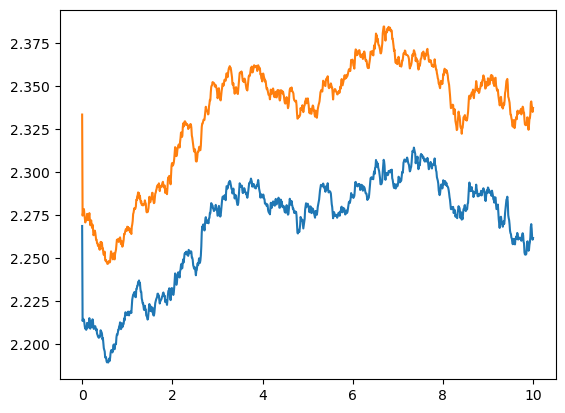

In [7]:
timestamps = np.linspace(0,10,1000) #time in hours
t, target_star_pwv, target_star_phase, target_star_mean = power_spectrum(12000, 1, 24000, timestamps, mean = 2)
t1, comparison_star_pwv, _, _ = power_spectrum(12000, 1, 24000, timestamps, mean = target_star_mean, target = False, phase = target_star_phase, separation = 25)

plt.plot(t, target_star_pwv)
plt.plot(t, comparison_star_pwv)
plt.show()


In [8]:
def photon_noise(flux, bin_size, mirror_diameter = 1, exp_time = 60, throughput = .4):
    
    mirror_area = np.pi*((mirror_diameter/2)**2) - np.pi*((.25)**2)
    #print("mirror area:"+str(mirror_area))
    
    #bin_size_array = [bin_array[1]-bin_array[0]]
    '''
    i=0
    for n in bin_array:
        if i == len(bin_array)-1:
            break
        bin_size2 = bin_array[i+1] - bin_array[i]
        bin_size_array.append(bin_size2)
        j+=1
    '''
    num_photons = flux*mirror_area*exp_time*throughput*bin_size
    print("num photons:"+str(num_photons))
    noise_std_dev = 1/(num_photons**(1/2))
    print("noise std dev:"+str(noise_std_dev))
    
    photon_noise_gaussian = np.random.normal(1, noise_std_dev, len(flux))
    
    return photon_noise_gaussian

In [9]:
#planet_atm = ascii.read("planet_atm_spec.dat")
#planet_atm
#atm_depth = planet_atm["col6"]
#atm_wave = planet_atm["col1"]
#atm_wave

In [10]:
'''
function that takes in stellar spectrum, wave range, and res. Output is timeseries of flux based on pwv variability,
one timeseries for each wavelength. 
'''


def binned_flux_pwv_v2(spectrum, pwv_input, wave_in, wave_out, res):
    stellar = spec_wave_range(spectrum, wave_in, wave_out)
    stellar_wave = stellar[0]
    stellar_flux = stellar[1]
    #pwv = np.load("pwv_target.npy")
    
    
    transmission_array = []
    
    i=0
    for n in stellar_wave:
        str_value = str(stellar_wave[i])
        value = stellar_wave[i]/10
        stellar_flux_value = stellar_flux[i]
        transmission  = interpolate_water(pwv_input, value)
        flux = stellar_flux_value*transmission
        d[str_value+"_trans_array"] = np.array(flux)
    
        transmission_array.append(d[str_value+"_trans_array"])
        i+=1
        
    transmission_array = np.array(transmission_array)
    
    #time_array = np.arange(0, 627, 1)
    
    transmission_array_binned = []
    #wave_in_converted = wave_in*1000
    #wave_out_converted = wave_out*1000
    wave_in_converted = wave_in*100
    wave_out_converted = wave_out*100
    
    print(stellar_wave)
    j=0
    for n in time_array:
        
        bin_1 = res_bin_timestamp(transmission_array[:,j], stellar_wave, res, wave_in_converted, wave_out_converted)
        transmission_array_binned.append(bin_1)
        j+=1
    
    return(transmission_array_binned)

In [11]:
#transmission_array

In [12]:
'''
tweaked binning function that allows binning at every point in the pwv timeseries
'''

def res_bin_timestamp(flux, wavelength, res, wave_in, wave_fin, spectrum_type="stellar"):
    #print(wavelength)
    #print
    print(flux)
    wave_in = wavelength[0]
    wave_fin = wavelength[-1]
    wave_array = [wave_in]
    n=wave_array[0]
    i=0
    #print(wave_in)
    #print(wave_fin)
    while wave_in <= n <= wave_fin:
        if wave_array[i] >= wave_fin:
            break
        bin_size = wave_array[i]/res
        if wave_array[i]+bin_size >= wave_fin:
            break
        wave_array.append(wave_array[i]+bin_size)
        n=wave_array[i]
        i+=1
    #print(wave_array)
    
    
        
    if spectrum_type == "stellar":
        
        wave_in_index = 0
        wave_out_index = -1
        
        '''
        use this section if using binning function individually and need to specify wave range
        wave_in_index = np.where(wavelength == wave_in*10)[0]
        print(wave_in_index)
        wave_out_index = np.where(wavelength == wave_fin*10)[0]
        print(wave_out_index)
        '''

        wavelength_range = wavelength[wave_in_index:wave_out_index]
        #print(wavelength_range)
        #finds step size of stellar spectrum
        
        high_res_step = [wavelength_range[1]-wavelength_range[0]]
        j=0
        for n in wavelength:
            if j == len(wavelength_range)-1:
                break
            bin_size2 = wavelength_range[j+1] - wavelength_range[j]
            high_res_step.append(bin_size2)
            j+=1
        
        #flux must be multiplied by fractional step size in order to scale it for binning
        #flux = (spectrum.flux.value)*high_res_step
        flux_new = (flux[wave_in_index:wave_out_index])*high_res_step
        #print(high_res_step)
        #print(len(flux_new))
        #print(len(wavelength_range))
        print(len(flux_new))
        
        
    elif spectrum_type == "earth":
        wavelength = spectrum["col1"]
        flux = spectrum["col2"]
    
    #plt.hist(wavelength_range, bins=wave_array, weights=flux_new)
    #plt.show()
    return np.histogram(wavelength_range, bins=wave_array, weights=flux_new)


In [13]:
def diff_spec_v2_pt1_transit(target_temp, ref_temp, mag1, mag2):
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    return target_spec, ref_spec

def diff_spec_v2_pt2_transit(target_spec, ref_spec, target_pwv, ref_pwv, wave_in, wave_out, res=200, exp_time = 3600, throughput = .4):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    #wave_array = target_binned_all[1]
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = division_noise_transit(target_stacked, ref_stacked)
    return diff

def diff_spec_v2_pt3_transit(diff):
    normalized_array = []
    i=0
    for n in diff:
        diff_mean = np.mean(diff[i])
        normalized = (diff[i]-diff_mean)/diff_mean
        normalized_array.append(normalized)
        i+=1    
    return normalized_array

In [14]:
import batman

params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period 
params.rp = .07                       #planet radi`us (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
model = batman.TransitModel(params, t)    #initializes model

In [15]:
transit = model.light_curve(params)
#plt.plot(transit)

#transit

In [17]:
planet_atm_abs4 = ascii.read("planet_atm_spec_1.65-2.1.dat")
depth_atm_wave_abs4 = planet_atm_abs4["col1"]
depth_atm_abs4 = planet_atm_abs4["col6"]

planet_atm_abs3 = ascii.read("planet_atm_spec_1.25-1.56.dat")
depth_atm_wave_abs3 = planet_atm_abs3["col1"]
depth_atm_abs3 = planet_atm_abs3["col6"]

planet_atm_abs2 = ascii.read("planet_atm_spec_.85-1.dat")
depth_atm_wave_abs2 = planet_atm_abs2["col1"]
depth_atm_abs2 = planet_atm_abs2["col6"]

planet_atm_abs1 = ascii.read("planet_atm_spec_1-1.2.dat")
depth_atm_wave_abs1 = planet_atm_abs1["col1"]
depth_atm_abs1 = planet_atm_abs1["col6"]
#depth_atm

In [18]:
#depth_atm[49]

In [24]:
'''
function that takes in stellar spectrum, wave range, and res. Output is timeseries of flux based on pwv variability,
one timeseries for each wavelength. 

This version adds in exoplanet transit.
'''




def binned_flux_pwv_transit(spectrum, pwv_input, wave_in, wave_out, res, rp = .07):
    stellar = spec_wave_range(spectrum, wave_in, wave_out)
    stellar_wave = stellar[0]
    stellar_flux = stellar[1]
    #pwv = np.load("pwv_target.npy")
    t = np.linspace(-0.025, 0.025, len(pwv_input))
    bulk_transit_depth = params.rp**2

    
    transmission_array = []
    
    i=0
    for n in stellar_wave:
        str_value = str(stellar_wave[i])

        value = stellar_wave[i]/10
        stellar_flux_value = stellar_flux[i]
        transmission  = interpolate_water(pwv_input, value)
        
        atm_transit_i = depth_atm[i]
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        rp_i = np.sqrt(total_transit_depth)
        params.rp = rp_i
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        
        flux = stellar_flux_value*transmission
        transit_flux = transit*flux
        
        d[str_value+"_trans_array"] = np.array(transit_flux)
        
        transmission_array.append(d[str_value+"_trans_array"])
        i+=1
        
    transmission_array = np.array(transmission_array)
    
    time_array = np.arange(0, len(pwv_input), 1)
    
    transmission_array_binned = []
    wave_in_converted = wave_in*1000
    wave_out_converted = wave_out*1000
    
    j=0
    for n in time_array:
        bin_1 = res_bin_timestamp(transmission_array[:,j], stellar_wave, res, wave_in_converted, wave_out_converted)
        transmission_array_binned.append(bin_1)
        j+=1
    
    return(transmission_array_binned)

In [27]:
'''
right now transit is being added before binning. It probably needs to be added after binning. 
I think writing a new function is the best way to do this, or maybe after stacking?
'''

target_spec, ref_spec = diff_spec_v2_pt1_transit(4000, 6000, 6, 7)
diff2 = diff_spec_v2_pt2_transit(target_spec, ref_spec, target_star_pwv, comparison_star_pwv, 1.65, 2.1)
diff_spec = diff_spec_v2_pt3_transit(diff2)

TypeError: diff_spec_v2_pt2_transit() missing 1 required positional argument: 'atm'

In [ ]:
plt.plot(diff_spec[46])

In [28]:
%run Interpolate_final.ipynb
%run Binning_final.ipynb
%run AddNoise_final.ipynb
%run GetSpectra_final.ipynb

In [44]:
def division_noise_transit(target_array, ref_array, atm):
    new_array1 = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.025, 0.025, 1000)
    bulk_transit_depth = params.rp**2
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col6"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col6"][i]/10**6
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        rp_i = np.sqrt(total_transit_depth)
        params.rp = rp_i
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        
        #flux = stellar_flux_value*transmission
        transit_flux = transit*target_array_i
        #print("flux with transit"+str(transit_flux[0:10]))
        
        
        ref_array_i = np.array(ref_array[0][:,i])
        target_noise = photon_noise(transit_flux, bin_size)
        ref_noise = photon_noise(ref_array_i, bin_size)
        noisy_target_i = target_noise*transit_flux
        noisy_ref_i = ref_noise*ref_array_i
        divided_i = noisy_target_i/noisy_ref_i
        new_array1.append(divided_i)
        i+=1
        #if i == 3:
            #break
    return new_array1

#cold_star_abs1_test3[:,0]


In [22]:
def diff_spec_v2_pt1_transit(target_temp, ref_temp, mag1, mag2):
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    return target_spec, ref_spec

def diff_spec_v2_pt2_transit(target_spec, ref_spec, target_pwv, ref_pwv, wave_in, wave_out, atm, res=200, exp_time = 3600, throughput = .4):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    #wave_array = target_binned_all[1]
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = division_noise_transit(target_stacked, ref_stacked, atm)
    return diff

def diff_spec_v2_pt3_transit(diff):
    normalized_array = []
    i=0
    for n in diff:
        diff_mean = np.mean(diff[i])
        normalized = (diff[i]-diff_mean)/diff_mean
        normalized_array.append(normalized)
        i+=1    
    return normalized_array

In [ ]:
target_spec_transit, ref_spec_transit = diff_spec_v2_pt1_transit(4000, 4500, 1, 1)

In [ ]:
target_binned_transit = binned_flux_pwv_v2(target_spec_transit, target_star_pwv, 1.65, 2.1, 200)

In [ ]:
ref_binned_transit = binned_flux_pwv_v2(ref_spec_transit, comparison_star_pwv, 1.65, 2.1, 200)

In [ ]:
target_stacked_transit = stacking(target_binned_transit)

In [ ]:
ref_stacked_transit = stacking(ref_binned_transit)

In [ ]:
division_transit = division_noise_transit(target_stacked_transit, ref_stacked_transit, planet_atm_abs4)

In [ ]:
division_transit[0]
plt.plot(division_transit[40])

In [29]:
target_spec, ref_spec = diff_spec_v2_pt1_transit(4000, 5000, 2, 3)
diff2 = diff_spec_v2_pt2_transit(target_spec, ref_spec, target_star_pwv, comparison_star_pwv, 1.65, 2.1, planet_atm_abs4)
diff_spec = diff_spec_v2_pt3_transit(diff2)

[[2428.80565138 2373.73537992 2371.67865959 ... 1398.85173754
  1668.45871012 1733.327163  ]
 [2428.89364523 2373.81746552 2371.73123787 ... 1399.08272623
  1668.73765814 1733.50973391]
 [2428.89164584 2373.81560038 2371.73004319 ... 1399.07747771
  1668.7313199  1733.50558555]
 ...
 [2428.81644674 2373.74545044 2371.68511006 ... 1398.88007596
  1668.49293234 1733.34956137]
 [2428.81835593 2373.74723144 2371.68625084 ... 1398.88508768
  1668.49898462 1733.35352258]
 [2428.81688344 2373.74585782 2371.685371   ... 1398.88122232
  1668.49431672 1733.35046745]]
[[768.45373621 755.53787459 759.88798619 ... 422.48737655 503.08077642
  524.14814511]
 [768.48311588 755.56556652 759.90572204 ... 422.56194184 503.16958604
  524.2077403 ]
 [768.48219924 755.56470253 759.90516868 ... 422.5596154  503.16681519
  524.20588093]
 ...
 [768.45251207 755.53672077 759.8872472  ... 422.48426968 503.07707604
  524.14566199]
 [768.45298152 755.53716325 759.8875306  ... 422.48546115 503.07849512
  524.146614

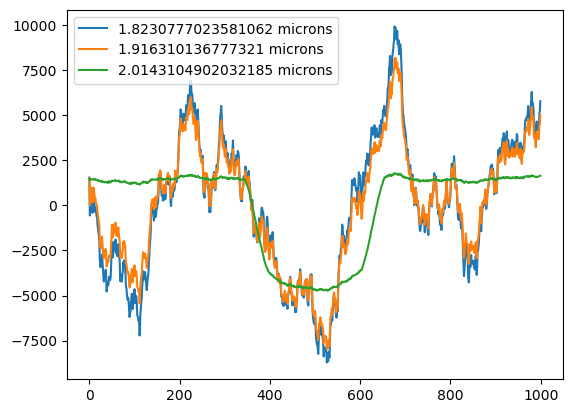

In [41]:
wave_range_abs4 = bin_array(1.65, 2.1, 200)

#plt.plot(diff_spec[0]*10**6, label=str(wave_range[0])+" microns")
#plt.plot(diff_spec[10]*10**6, label=str(wave_range[10])+" microns")
#plt.plot(diff_spec[15]*10**6, label=str(wave_range[15])+" microns")
#plt.plot(diff_spec[17]*10**6, label=str(wave_range[17])+" microns")
#plt.plot(diff_spec[18]*10**6, label=str(wave_range[18])+" microns")
plt.plot(diff_spec[20]*10**6, label=str(wave_range_abs4[20])+" microns")
plt.plot(diff_spec[30]*10**6, label=str(wave_range_abs4[30])+" microns")
plt.plot(diff_spec[40]*10**6, label=str(wave_range_abs4[40])+" microns")
#plt.plot(diff_spec[40])
#plt.plot(diff_spec[47])
plt.legend()

In [31]:
len(planet_atm_abs2["col6"])

33

In [45]:
target_spec_abs2, ref_spec_abs2 = diff_spec_v2_pt1_transit(4000, 6000, 5, 7)
diff_abs2 = diff_spec_v2_pt2_transit(target_spec_abs2, ref_spec_abs2, target_star_pwv, comparison_star_pwv, 1, 1.2, planet_atm_abs2)
diff_spec_abs2 = diff_spec_v2_pt3_transit(diff_abs2)

[[ 95.40544235  94.96683423  96.65901034 ... 106.28710953 107.68989345
  110.61912793]
 [ 95.40889919  94.97019958  96.66091615 ... 106.38085475 107.77093592
  110.67212755]
 [ 95.40882065  94.97012311  96.66087285 ... 106.37872468 107.76909447
  110.67092329]
 ...
 [ 95.40586645  94.96724711  96.65924415 ... 106.29861049 107.69983599
  110.62563009]
 [ 95.40594145  94.96732012  96.6592855  ... 106.30064446 107.70159436
  110.62678001]
 [ 95.4058836   94.96726381  96.65925361 ... 106.29907573 107.70023819
  110.62589312]]
[[19.12908945 18.80413949 19.28316111 ... 17.68811774 17.81906455
  18.28443121]
 [19.12983961 18.80484137 19.28356027 ... 17.70472338 17.8334375
  18.29372794]
 [19.12981621 18.80481947 19.28354781 ... 17.70420529 17.83298906
  18.29343788]
 ...
 [19.12905819 18.80411024 19.28314448 ... 17.68742585 17.81846568
  18.28404384]
 [19.12907018 18.80412146 19.28315086 ... 17.68769118 17.81869535
  18.2841924 ]
 [19.12904045 18.80409364 19.28313504 ... 17.68703307 17.818125

1.1048955771867306


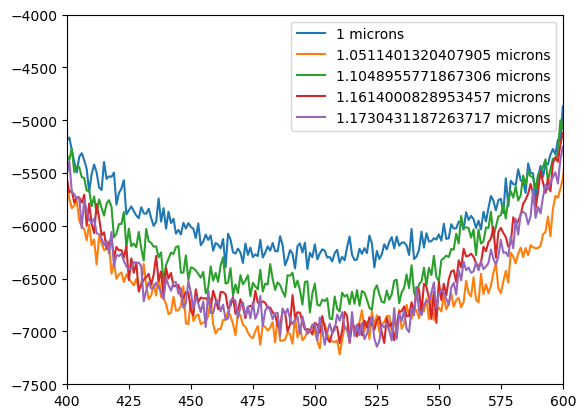

In [66]:
wave_range_abs2 = bin_array(1, 1.2, 200)

#plt.plot(diff_spec[0]*10**6, label=str(wave_range[0])+" microns")
#plt.plot(diff_spec[10]*10**6, label=str(wave_range[10])+" microns")
#plt.plot(diff_spec[15]*10**6, label=str(wave_range[15])+" microns")
#plt.plot(diff_spec[17]*10**6, label=str(wave_range[17])+" microns")
#plt.plot(diff_spec[18]*10**6, label=str(wave_range[18])+" microns")
plt.plot(diff_spec_abs2[0]*10**6, label=str(wave_range_abs2[0])+" microns")
plt.plot(diff_spec_abs2[10]*10**6, label=str(wave_range_abs2[10])+" microns")
plt.plot(diff_spec_abs2[20]*10**6, label=str(wave_range_abs2[20])+" microns")
plt.plot(diff_spec_abs2[30]*10**6, label=str(wave_range_abs2[30])+" microns")
plt.plot(diff_spec_abs2[32]*10**6, label=str(wave_range_abs2[32])+" microns")
#plt.plot(diff_spec[30]*10**6, label=str(wave_range[30])+" microns")
#plt.plot(diff_spec_abs2[20]*10**6, label=str(wave_range_abs2[20])+" microns")
#plt.plot(diff_spec_abs2[30]*10**6, label=str(wave_range_abs2[30])+" microns")
#plt.plot(diff_spec_abs2[35]*10**6, label=str(wave_range_abs2[35])+" microns")
#plt.plot(diff_spec[40])
#plt.plot(diff_spec[47])
ax = plt.gca()
ax.set_xlim(400,600)
ax.set_ylim(-7500, -4000)
plt.legend()

print(wave_range_abs2[20])

In [ ]:
target_spec_abs1, ref_spec_abs1 = diff_spec_v2_pt1_transit(5000, 6000, 8, 10)
diff_abs1 = diff_spec_v2_pt2_transit(target_spec_abs1, ref_spec_abs1, target_star_pwv, comparison_star_pwv, 1.25, 1.56, planet_atm_abs3)
diff_spec_abs1 = diff_spec_v2_pt3_transit(diff_abs1)

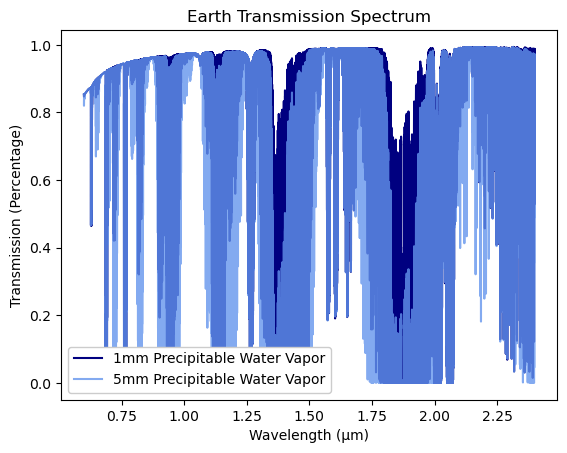

In [91]:
d["data5.0_pd"]
plt.plot(d["data1.0_pd"]["col1"]/1000, d["data1.0_pd"]["col2"], color="navy", alpha= 1, label="1mm Precipitable Water Vapor")

plt.plot(d["data1.0_pd"]["col1"]/1000, d["data5.0_pd"]["col2"], color="cornflowerblue",alpha = .8, label="5mm Precipitable Water Vapor")

plt.legend(loc="lower left", framealpha = 1)

plt.title("Earth Transmission Spectrum")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission (Percentage)")

plt.savefig("Transmission_Spectrum.pdf")
#ax = plt.gca()
#ax.set_xlim(.85, 1.2)